In [3]:
%matplotlib inline
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ニューラルネットワークモデル
## ニューロンモデル
ニューラルネットワークは **ニューロンモデル** を単位として構築される。ニューロンモデルは脳の神経細胞からヒントを得て考案された数理モデルで、入力変数x_iへ各々の重みw_iを掛け、その総和をシグモイド関数 (最近は別関数が人気) に入れたものになる。この式は **ロジスティック回帰モデルそのもの** となり、学習とは重みwの調整を指すことになる。

$$
\begin{align}
    入力総和:      && a &= \sum_{i}w_ix_i \\
    ニューロン出力: && y &= \sigma(a) = \frac{1}{1 + \exp(-a)} \\
    誤差関数:      && E &= -\frac{1}{N}\sum_{n}{t_n \log y_n + (1 - t_n)\log (1 - y_n)} \\
    導関数:        && \frac{\partial E}{\partial w_i} &= \frac{1}{N}\sum_{n}(y_n - t_n)x_{ni} \\
\end{align}
$$

## ニューラルネットワーク
ニューロンモデルは入力空間を線で分ける単純な機能しかないが、組み合わせると柔軟な表現力を持つようになる。特に出力の逆戻りする経路が無く、一方向にのみ流れるモデルを **フィードフォワードニューラルネットワーク(FNN)** と呼ぶ。

ここでは2入力3クラス分類の2層FNNを念頭に進める。この場合は次の式で表現される。hは **活性化関数** と呼び、当分は中間層にはシグモイド関数、出力層にはソフトマックス関数を使う。ちなみに、コードを読む際は各層への入力にバイアス項が加わっている点に注意。

$$
\begin{align}
    中間層の入力総和: && b_j &= \sum_{d} w_{jd}x_d \\
    中間層の出力:    && z_j &= h_1(b_j) \\
    出力層の入力総和: && a_k &= \sum_{j} v_{kj}z_j \\
    出力層の出力:    && y_k &= h_2(a_k) = \frac{\exp(a_k)}{\sum_{l=0}^{K} \exp(a_l)} = \frac{\exp(a_k)}{u} \\
\end{align}
$$

## サンプルデータ

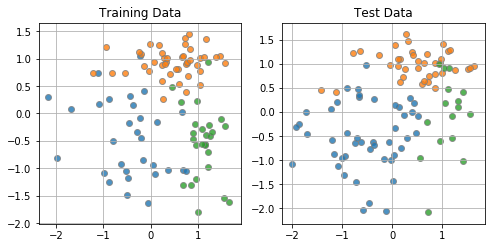

In [5]:
np.random.seed(seed=1)
N, D, M, K = 200, 2, 2, 3

# クラス値T生成 (3クラス分類)
Mu = np.array([[-0.5, -0.5], [0.5, 1.0], [1.0, -0.5]])  # 分布の中心
Sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])  # 分布の分散
Pi = np.array([0.4, 0.8, 1.0])  # (A) 各分布への割合 0.4 0.8 1
wk = np.random.rand(N)

T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
np.random.seed(seed=1)  # 乱数を固定
for n in range(N):
    wk = np.random.rand()
    for k in range(K): # (B)
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = (np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k])

TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training,:]
X_test = X[X_n_training:,:]
T_train = T[:X_n_training,:]
T_test = T[X_n_training:,:]

# 可視化
def show_data(x, t):
    plt.grid(True)
    for k in range(t.shape[1]):
        plt.scatter(
            x[t[:, k] == 1, 0],
            x[t[:, k] == 1, 1], edgecolor="gray", alpha=0.8)

plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
plt.title("Training Data")
show_data(X_train, T_train)

plt.subplot(1, 2, 2)
plt.title("Test Data")
show_data(X_test, T_test)

## FNN実装コード
中間層の重みw、出力層の重みvは束ねて1次元配列wvとして保持。fnn関数内でw, vに分けて使う。これら2つは縦に出力ノード番号、横に入力ノード番号の組み合わせで重みが格納されている。計算する際にはバイアス項をnp.ones()で追加している他、計算効率化のため、重み行列を転置し、内積で計算を行う。

In [6]:
def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

def softmax(x):
    x = np.exp(x)
    y = x / np.sum(x, axis=-1, keepdims=True)
    return y

def fnn(wv, m, k, x):
    """
    FNN実装コード
    
    Parameters
    -----------
    wv: np.ndarray
        重み付け[m * d + k * m]
    m: int
        中間層のノード数
    k: int
        出力層のノード数
    x: np.ndarray
        入力データ[n, d]
    
    Returns
    -----------
    y: 出力層[n, k]
    a: 出力層入力総和[n, k]
    z: 中間層出力[n, m]
    b: 中間層入力総和[n, m]
    """
    
    n, d = x.shape
    bias = np.ones((n, 1))
    
    # 中間層
    w = wv[:m * (d + 1)]
    w = w.reshape(m, d + 1)
    w = w.T
    x = np.hstack((x, bias))
    b = x @ w
    z = sigmoid(b)
    
    # 出力層
    v = wv[m * (d + 1):]
    v = v.reshape(k, m + 1)
    v = v.T
    z = np.hstack((z, bias))
    a = z @ v
    y = softmax(a)
    
    return y, a, z, b

# 動作確認
wv = np.ones(M * (D + 1) + K * (M + 1))
fnn(wv, M, K, X_train[:2])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839],
        [-1.12079826, -1.12079826]]))

## 数値解
組み上げた2層FNNで3クラス分類を解かせる。最初は数値微分法を使う。この方法は後に扱う解析解と比較し計算速度が遅い欠点があるが、偏微分を行わなくても勾配ベクトルを求められるメリットが有る。

誤差関数と数値解の導関数は次の通り。数値微分法は傾きを導出したいパラメータのうち、偏微分する変数へ十分に小さい数値(e)を足した版と引いた版の2つを計算。これの和を2eで割る事で任意のx_iで偏微分を行う。これは傾きを調べたい地点の前後の変化を調べる事で傾きを出していると言え、微分の考え方そのものである。これをパラメータの数だけ行う事で任意のxでのyの勾配ベクトルが出る。

$$
\begin{align}
    E(w, v)
        &= -\frac{1}{N}\sum_n\sum_k t_{nk}\log(y_{nk}) \\
    \left.\frac{\partial E}{\partial w_0} \right|_{w_0^*w_1^*w_2^*}
        &\cong \frac{E(w_0^* + \epsilon, w_1^*, w_2^*) - E(w_0^* - \epsilon, w_1^*, w_2^*)}{2\epsilon}
\end{align}
$$

1.0986122886681098
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


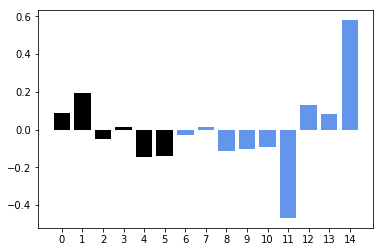

In [20]:
def ce_fnn(wv, m, k, x, t):
    n, d = x.shape
    y, a, z, b = fnn(wv, m, k, x)
    ce = t.reshape(-1) @ np.log(y.reshape(-1)) / n
    return -ce

def dce_fnn_num(wv, m, k, x, t):
    eps = 0.001
    dwv = np.empty_like(wv)
    for iwv in range(len(wv)):
        wv_modified = np.copy(wv)
        wv_modified[iwv] = wv[iwv] - eps
        mse1 = ce_fnn(wv_modified, m, k, x, t)
        wv_modified[iwv] = wv[iwv] + eps
        mse2 = ce_fnn(wv_modified, m, k, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * eps)
    return dwv

def show_wv(wv):
    n = wv.shape[0]
    idx = np.arange(M * (D + 1) + K * (M + 1))
    plt.bar(idx[:M * (D + 1)], wv[:M * (D + 1)], align="center", color="black")
    plt.bar(idx[M * (D + 1):], wv[M * (D + 1):], align="center", color="cornflowerblue")
    plt.xticks(idx)

# 動作確認 (交差エントロピー誤差)
np.random.seed(1)
wv = np.ones(15)
print(ce_fnn(wv, M, K, X_train[:2], T_train[:2]))

# 動作確認 (勾配ベクトル)
wv = np.random.normal(0, 1, M * 3 + K * (M + 1))
dwv_num = dce_fnn_num(wv, M, K, X_train[:2, :], T_train[:2, :])
print(dwv_num)
show_wv(dwv_num)

実際に勾配ベクトルを1000回辿らせて学習させる。  
その際、交差エントロピー誤差と各パラメータの時間経過による変化をプロットする。

途中で誤差が減少しなくなることに注目。これは鞍点付近を通過すると起こり、重みを更新する方向に変化が起きている。非線形性の強いニューラルネットワークでは誤差関数の生み出す地形は複雑な形状をとるため、学習が収束したようにみえても更に進めることで再び学習が進み始めることがある。このように、学習ステップ数をどれくらいとるかは重要なパラメータとなる。

In [7]:
def fit_fnn_num(wv_init, m, k, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.empty(n)
    err_test = np.empty(n)
    wv_hist = np.empty((n, len(wv_init)))
    epsilon = 0.001
    
    for i in range(n):
        wvt = wvt - alpha * dce_fnn_num(wvt, m, k, x_train, t_train)
        err_train[i] = ce_fnn(wvt, m, k, x_train, t_train)
        err_test[i] = ce_fnn(wvt, m, k, x_test, t_test)
        wv_hist[i] = wvt
    
    return wvt, wv_hist, err_train, err_test

np.random.seed(1)
wv_init = np.random.normal(0, 0.01, M * (D + 1) + K * (M + 1))
n_step = 1000
alpha = 0.5

%time res = fit_fnn_num(wv_init, M, K, X_train, T_train, X_test, T_test, n_step, alpha)
wv, wv_hist, err_train, err_test = res

Wall time: 2.56 s


In [18]:
def show_fnn(wv, m, k):
    xn = 60
    x0 = np.linspace(*X_range0, xn)
    x1 = np.linspace(*X_range1, xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.hstack((xx0.reshape(-1, 1), xx1.reshape(-1, 1)))
    y, a, z, b = fnn(wv, m, k, x)
    
    for k in range(K):
        f = y[:,k]
        f = f.reshape(xn, xn)
        cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=["cornflowerblue", "black"])
        cont.clabel(fmt = "%1.1f", fontsize=9)
    plt.xlim(X_range0)
    plt.xlim(X_range1)


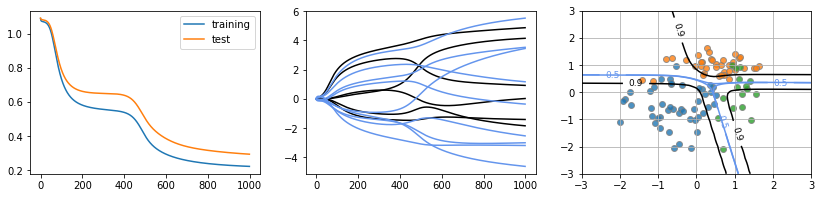

In [8]:
plt.figure(figsize=(14, 3))

# 誤差平均
plt.subplot(1, 3, 1)
plt.plot(err_train, label="training")
plt.plot(err_test, label="test")
plt.legend()

# パラメータの時間経過
plt.subplot(1, 3, 2)
plt.plot(wv_hist[:,:M * (D + 1)], color="black", label="w")
plt.plot(wv_hist[:,M * (D + 1):], color="cornflowerblue", label="v")

# 分類結果
plt.subplot(1, 3, 3)
show_data(X_test, T_test)
show_fnn(wv, M, K)

## 誤差逆伝播法
数値解では計算コストが大きい。よって次に勾配法を用いた方法を取り扱う。FNNにおける勾配法では誤差逆伝播法が有名である。この方法はネットワークの出力で生じる誤差を使用し、出力層の重みから中間層の重みへと入力方向と逆向きに重みを更新することからこの名前が付けられている。この数式は数理的にFNN用の勾配法そのものといえるものになる。

まず、FNNの交差エントロピー誤差の式を定義する。交差エントロピー誤差は(1)の式になるが、データ1件ずつに着目した場合には(1)は(2)の平均値を求めている。このE_n(w, v)の各引数の勾配を求めることでパラメータの更新値を導出していく。

$$
\begin{align}
    E(w, v) &= -\frac{1}{N}\sum_{n}\sum_{k}t_{nk}\log y_{nk} =  \frac{1}{N}\sum_{n}E_n(w, v) \tag{1} \\
    E_n(w, v) &= -\sum_{k}t_k\log y_k \tag{2}
\end{align}
$$

### vを偏微分する

E_n(w, v)を出力層の重み(v)で偏微分する。出力層の入力総和を関数aとすれば、連鎖律を用いて次の式が作れる。それぞれの式は次のようになる。

$$
\begin{align}
    \frac{\partial E_n}{\partial v_{jk}}
        &= \frac{\partial E_n}{\partial a_k}\frac{\partial a_k}{\partial v_{jk}} \\
    \frac{\partial E_n}{\partial a_k}
        &= -t_k\frac{1}{y_k}y_k(1 - y_k) - \sum_{c \neq k}t_c\frac{1}{y_c}(-y_cy_i) \\
        &= -t_k(1 - y_k) + \sum_{c \neq k}t_cy_k \\
        &= -t_k + t_ky_k + \sum_{c \neq k}t_cy_k \\
        &= \sum_c t_cy_k - t_k \\
        &= y_k - t_k \\
    \frac{\partial a_k}{\partial v_{kj}} &= z_j \\
\end{align}
$$


上の導出に使用している式を記載する。E(w, v)やa_kはFNNの定義。出力層は活性化関数にソフトマックス関数が使われているが、この関数の導関数も記述する。

$$
    E_n(w, v) = -\sum_{k}t_k\log y_k \quad
    a_k = \sum_{j=0}^{M} v_{kj}z_j \quad
    \frac{\partial y_j}{\partial a_i} =
        \begin{cases}
            y_j(1 - y_i) & (i = j) \\ 
            -y_j y_i & (i \neq j)
        \end{cases} \\
$$

a_k導関数は式の構造的に出力層(2層)の誤差を表す。この導関数は他層の導関数でも使う重要な式となるため、デルタ_k^(2)と書く。この式へzkを掛けるとE_nをvで偏微分する導関数になる。その式は学習データとモデル式での出力の誤差を元に、出力層への入力を掛ける事で出力への貢献の大きさに応じた重み補正を行っている式になる。

$$
\begin{align}
    \frac{\partial E_n}{\partial a_k} &= y_k - t_k = \delta_k^{(2)} \\
    \frac{\partial a_k}{\partial v_{kj}} &= z_j \\
    \frac{\partial E_n}{\partial v_{kj}} &= \delta_k^{(2)}z_j
\end{align}
$$


### wを偏微分する
次に隠れ層の重み(w)で偏微分する。隠れ層(1層)の導関数は次のようにすると出力層の重みの式とほぼ同じになる。すなわち、デルタj(1)を求める事で目的の導関数が出る。ちなみに2行目の式のシグマは偏微分の連鎖律を使っている。

$$
\begin{align}
    \frac{\partial E_n}{\partial w_{ji}} &= \delta_j^{(1)}x_i \\
    \frac{\partial E_n}{\partial b_j}
        &= \delta_j^{(1)}
         =
           \sum_k
           \left(\frac{\partial E_n}{\partial a_k}\frac{\partial a_k}{\partial z_j}\right)
           \frac{\partial z_j}{\partial b_j} 
         = h^{\prime}(b_j)\sum_k \delta_k^{(2)}v_{jk} \\
    \frac{\partial b_j}{\partial w_{ji}} &= x_i \\
\end{align}
$$

上の導出に使用している式を記載する。

$$
    b_j = \sum_d w_{dj}x_d \quad
    z_j = h(b_j) \quad
    a_k = \sum_j v_{jk}z_j \quad
    E_n(w, v) = -\sum_{k}t_k\log y_k
$$

* x → n\*d
* z → n\*j
* y → n\*k
* デルタ^(1) → n\*j
* デルタ^(2) → n\*k

### 行列計算で求める
デルタ^(x)を求めると各層の重みの導関数に共通性が見いだせる点に注目。このデルタは同じ意味で様々な機械学習の資料で登場する。その際、この部分は導関数を求める層の活性化関数を通す前の入力総和までを微分したものと捉えると良い。

$$
\begin{align}
    \boldsymbol{h}^\prime &= \boldsymbol{z}(1 - \boldsymbol{z}) \\
    \boldsymbol{\delta}^{(2)} &= \boldsymbol{y} - \boldsymbol{t} \\
    \boldsymbol{\delta}^{(1)} &= \boldsymbol{h}^{\prime} \odot \boldsymbol{\delta}^{(2)} \boldsymbol{v}^T \\
    \frac{\partial\boldsymbol{E}}{\partial\boldsymbol{v}} &=
        \frac{1}{N}\sum_n \boldsymbol{z}_n \boldsymbol{\delta}^{(2)T}_n \\
    \frac{\partial\boldsymbol{E}}{\partial\boldsymbol{w}} &=
        \frac{1}{N}\sum_n \boldsymbol{x}_n \boldsymbol{\delta}^{(1)T}_n \\
\end{align}
$$

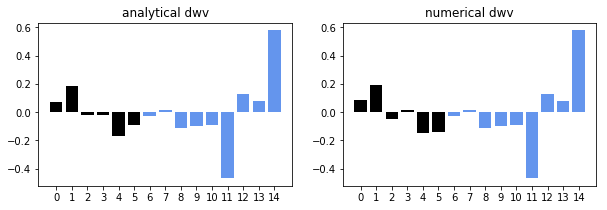

In [22]:
def dce_fnn_ana(wv, m, k, x, t):
    n, d = x.shape
    y, a, z, b = fnn(wv, m, k, x)
    
    # 出力層
    delta2 = y - t
    dv = z.reshape(n, m + 1, 1) @ delta2.reshape(n, 1, k)
    dv = np.mean(dv, axis=0)
    
    # 中間層
    v = wv[m * (d + 1):]
    v = v.reshape(k, m + 1)
    v = v.T
    delta1 = z * (1 - z) * delta2 @ v.T[:,:-1]
    x = x.reshape(n, d, 1)
    x = np.concatenate((x, np.ones((n, 1, 1))), axis=1)
    dw = x @ delta1.reshape(n, 1, m)
    dw = np.mean(dw, axis=0)
    
    dw = np.ravel(dw.T)
    dv = np.ravel(dv.T)
    dwv = np.concatenate((dw, dv))
    return dwv

np.random.seed(1)
wv_init = np.random.normal(0, 1, M * (D + 1) + K * (M + 1))
dwv_ana = dce_fnn_ana(wv_init, M, K, X_train[:2], T_train[:2])

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plt.title("analytical dwv")
show_wv(dwv_ana)

plt.subplot(1, 2, 2)
plt.title("numerical dwv")
show_wv(dwv_num)

In [10]:
def fit_fnn_ana(wv_init, m, k, x_train, t_train, x_test, t_test, n, alpha):
    wvt = wv_init
    err_train = np.empty(n)
    err_test = np.empty(n)
    wv_hist = np.empty((n, len(wv_init)))
    
    for i in range(n):
        wvt = wvt - alpha * dce_fnn_ana(wvt, m, k, x_train, t_train)
        err_train[i] = ce_fnn(wvt, m, k, x_train, t_train)
        err_test[i] = ce_fnn(wvt, m, k, x_test, t_test)
        wv_hist[i] = wvt
    
    return wvt, wv_hist, err_train, err_test

np.random.seed(1)
wv_init = np.random.normal(0, 0.01, M * (D + 1) + K * (M + 1))
n_step = 1000
alpha = 0.5

%time res = fit_fnn_ana(wv_init, M, K, X_train, T_train, X_test, T_test, n_step, alpha)
wv, wv_hist, err_train, err_test = res

Wall time: 350 ms


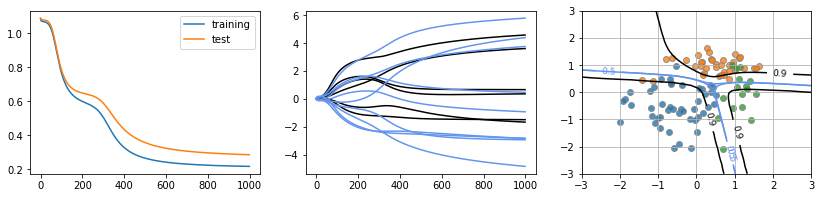

In [11]:
plt.figure(figsize=(14, 3))

# 誤差平均
plt.subplot(1, 3, 1)
plt.plot(err_train, label="training")
plt.plot(err_test, label="test")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(wv_hist[:,:M * (D + 1)], color="black", label="w")
plt.plot(wv_hist[:,M * (D + 1):], color="cornflowerblue", label="v")

plt.subplot(1, 3, 3)
show_data(X_test, T_test)
show_fnn(wv, M, K)

# ニューロンの特性と学習の仕組み
隠れ層のある2層FNNの出力は任意の関数に近似できることが証明されている。証明には高度な数学が用いられおり理解は難しいが、ここではサンプルパラメータでFNNの高い表現力の一端を示す。次のようにFNNは中間層2ノードで値の上昇と下降を表現でき、ノード数を増やせば増やすほど線形基底関数モデルの時のように表現力は向上する。また、層を重ねることによって各層の出力を基底関数とし、より指数関数的に複雑な表現力を得られる。

In [24]:
def fnn_dense(w, x, activation):
    """
    FNN1層分の実装
    
    Parameters
    -----------
    w: np.ndarray
        重み付け[m * d]
    x: np.ndarray
        入力データ[n, d]
    activation: func(x) -> y
        活性化関数
    
    Returns
    -----------
    z: 出力[n, m]
    b: 入力総和[n, m]
    """
    map
    n, d = x.shape
    bias = np.ones((n, 1))
    
    w = w.reshape(-1, d + 1)
    w = w.T
    x = np.hstack((x, bias))
    b = x @ w
    z = activation(b)
    
    return z, b

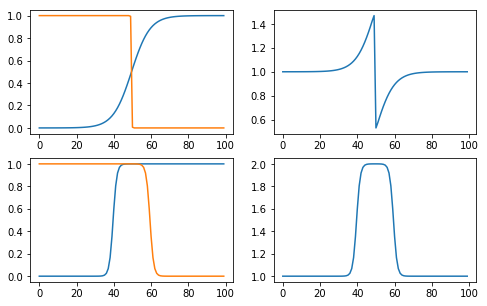

In [25]:
plt.figure(figsize=(8, 5))
x = np.linspace(-10, 10, 100).reshape(-1, 1)

# 上段
w = np.array([1, 0, -50, 0])
z, b = fnn_dense(w, x, sigmoid)
plt.subplot(2, 2, 1)
plt.plot(z)

v = np.array([1, 1, 0])
y, a = fnn_dense(v, z, lambda x: x)
plt.subplot(2, 2, 2)
plt.plot(y)

# 下段
w = np.array([5, 10, -5, 10])
z, b = fnn_dense(w, x, sigmoid)
plt.subplot(2, 2, 3)
plt.plot(z)

v = np.array([1, 1, 0])
y, a = fnn_dense(v, z, lambda x: x)
plt.subplot(2, 2, 4)
plt.plot(y)


# TensorFlowでニューラルネットワークを作る
ここまではニューラルネットワークを自前で作成してきたが、ライブラリを使用することで簡単に構築できる。ここから先はTensorFlow (TF) を使っていく。その際、TF.Kerasを使用する。これを使用すると大規模なニューラルネットワークでも比較的簡単に作成できる。

In [26]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

# TF GPU Option
# メモリを必要分だけ確保するよう設定 (事前に全量確保されるのを無効化)
conf = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config=conf)
keras.backend.set_session(sess)

In [27]:
# FNNモデリング
model = Sequential()
model.add(Dense(2, input_dim=2, activation="sigmoid", kernel_initializer="uniform"))
model.add(Dense(3, activation="softmax", kernel_initializer="uniform"))

# 学習アルゴリズム
sgd = keras.optimizers.SGD(lr=1, momentum=0.0, decay=0.0, nesterov=False)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

# 学習
%time res = model.fit(X_train, T_train, epochs=1000, batch_size=100, verbose=0, validation_data=(X_test, T_test))

# 評価
score = model.evaluate(X_test, T_test, verbose=0)
print("cross entropy {0:3.2f}, accuracy {1:3.2f}".format(*score[:2]))

Wall time: 8.69 s
cross entropy 0.26, accuracy 0.92


In [28]:
def show_fnn_keras(model):
    xn = 60
    x0, x1 = np.linspace(*X_range0, xn), np.linspace(*X_range1, xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.hstack((xx0.reshape(-1, 1), xx1.reshape(-1, 1)))
    y = model.predict(x)

    plt.xlim(X_range0)
    plt.xlim(X_range1)
    for k in range(K):
        f = y[:,k]
        f = f.reshape(xn, xn)
        cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=["cornflowerblue", "black"])
        cont.clabel(fmt = "%1.1f", fontsize=9)

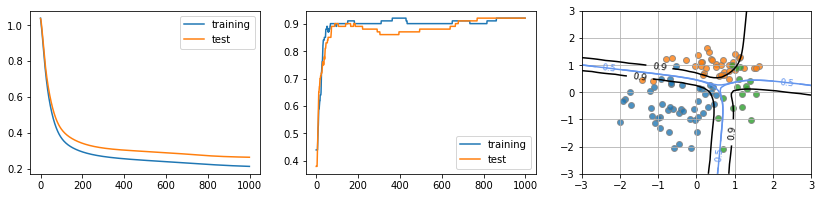

In [29]:
plt.figure(figsize=(14, 3))

# 誤差平均
plt.subplot(1, 3, 1)
plt.plot(res.history["loss"], label="training")
plt.plot(res.history["val_loss"], label="test")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(res.history["acc"], label="training")
plt.plot(res.history["val_acc"], label="test")
plt.legend()

plt.subplot(1, 3, 3)
show_data(X_test, T_test)
show_fnn_keras(model)